In [1]:
import xml.etree.cElementTree as ET
import pprint as pp
import re
import codecs
import json
import pymongo
import collections as col

In [2]:
#I choose Plaisir in France as my area (https://www.openstreetmap.org/export#map=13/48.8129/1.9484).
#I grew up in Plaisir and that is the reason for my choice.
#Please find the file downloadable here https://drive.google.com/open?id=0Bxw66CBwG5RORnlvbmRiNFdON2c

OSM_FILE = "plaisir.osm"

# Audit of the file

In [3]:
tags = {}
for event, elem in ET.iterparse("sample.osm"):
    if elem.tag not in tags:
        tags[elem.tag]= 1
    else:
        tags[elem.tag] += 1
print tags

{'node': 33069, 'nd': 46051, 'member': 1718, 'tag': 14808, 'relation': 45, 'way': 5618, 'osm': 1}


**What I will do to get a better view of the file?**
- Build a dictionnary to count :
    - the number and types of amenity, 
    - the number and types of shops, 
    - the number and types of sport.

In [4]:
tags_details = {}
keys = ["amenity","shop","sport","place","service","building"]

def create_tags_details(binder, list_keys, filename):
    for key in list_keys:
        binder[key] = {}
    for event, elem in ET.iterparse(filename, events = ("start",)):
        if elem.tag == "tag":
            for tag in elem.iter("tag"):
                for key in list_keys:
                    if elem.attrib["k"] == key:
                        if tag.attrib["v"] not in binder[key]:
                            binder[key][tag.attrib["v"]] = 1
                        else:    
                            binder[key][tag.attrib["v"]] += 1
    return binder

In [5]:
create_tags_details(tags_details,keys,"sample.osm")

{'amenity': {'atm': 2,
  'bank': 2,
  'bar': 2,
  'bench': 12,
  'bus_station': 1,
  'cafe': 1,
  'car_wash': 1,
  'clock': 1,
  'college': 1,
  'community_centre': 1,
  'doctors': 1,
  'fast_food': 3,
  'fountain': 1,
  'fuel': 2,
  'hospital': 1,
  'kindergarten': 1,
  'parking': 28,
  'parking_entrance': 2,
  'pharmacy': 2,
  'place_of_worship': 2,
  'post_box': 3,
  'recycling': 3,
  'restaurant': 4,
  'school': 13,
  'shelter': 1,
  'swimming_pool': 8,
  'telephone': 6,
  'theatre': 1,
  'vending_machine': 2,
  'waste_basket': 11},
 'building': {'chapel': 1,
  'church': 1,
  'commercial': 1,
  'house': 16,
  'industrial': 3,
  'office': 1,
  'residential': 16,
  'roof': 1,
  'school': 1,
  'train_station': 1,
  'yes': 4606},
 'place': {'hamlet': 1, 'town': 1, 'village': 1},
 'service': {'Parking': 1,
  'alley': 5,
  'driveway': 4,
  'emergency_access': 1,
  'parking_aisle': 43,
  'siding': 4,
  'yard': 3},
 'shop': {'bakery': 3,
  'butcher': 1,
  'clothes': 1,
  'convenience': 4,


**What questions I want to answer?**
- What is the most popular type of shop in Plaisir?
- What is the sport with the most facilities in Plaisir?
- Are there more restaurant or Fastfood in Plaisir?
- Is there a correlation between the number of house and the number of bus stop in a given area?

# Data cleaning plan

- Audit and clean:
    - addr:street 
    - addr:postcode
    - phone:
- Create a list with one document per tag (we will only care about node and way) and a workable structure.


**Audit street names**

In [6]:
# Create a dict to store weird street types
street_types = col.defaultdict(set)
# Create a list listing expected street types
expected_street_type = ["Rue", "Route", "Ruelle", "Cours", "Avenue", "Impasse", "Mail","Boulevard", "Square", "Place", "Allee"]
# Create a regular expression to isolate weird street types
street_type_re = re.compile(r'^\w+', re.IGNORECASE)


def audit_street(street_types,street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected_street_type:
            street_types[street_type].add(street_name)
    

def audit_street_map(file_in, street_types, pretty = False):
    for _, element in ET.iterparse(file_in):
        if element.tag == "way" or element.tag == "node":
            for tag in element.iter("tag"):
                if tag.attrib['k'] == "addr:street":
                    audit_street(street_types,tag.attrib["v"])
    pp.pprint(dict(street_types))

In [7]:
audit_street_map("plaisir.osm",street_types, True)

{'AVE': set(['AVE DE LA REPUBLIQUE']),
 u'All': set([u"All\xe9e de l'Aqueduc",
              u'All\xe9e de la R\xe9union',
              u'All\xe9e de la pommeraie',
              u'All\xe9e des M\xfbriers',
              u'All\xe9e des Noisetiers',
              u'All\xe9e des Orn\xe9s',
              u'All\xe9e des Romarins',
              u'All\xe9e des Yvelines']),
 'Centre': set(['Centre commercial SQY Ouest']),
 u'Chemin': set([u'Chemin D\xe9partemental 161']),
 'ROUTE': set(['ROUTE D ARMORIQUE']),
 'avenue': set(['avenue Salavdor Allende', 'avenue Salvador Allende']),
 'place': set([u'place de la M\xe9diath\xe8que', 'place du Beffroi']),
 'rue': set(["rue d'Athenes", 'rue de la gare', 'rue du Luxembourg'])}


One street type needs to be cleaned ('AVE'). We will clean that street type when shapping our data structure. Please find below the function we'll use to clean street types.

In [9]:
#check addr: with :
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')

def clean_street_type(address_tag,address_dict):
    """
    This function aims to transform address tags and add them as a key / value pair of a dedicated address dictionary. 
    The function will take the address tag and the address dictionary as arguments:
        address_tag: every sub tag of a "node" or "way" top level tag.
        address_dict: a dictionnary where we store key / value pair of adress elements (postcode, street, etc..)
    The function first creates a cleaned key based on the current key of the tag by removing the "addr:" part of the string.
    If after removing "addr:" the function still detects a colon, the tag isn't added to the dictionary because the data entry was not clean enought.
    Else, if the value of the tag starts with "AVE" as first word, "AVE" is replaced by "Avenue".
    Finally, the key / value is added to the address dictionary.
    """
    key = re.sub('addr:', '', address_tag['k']).strip()
    if lower_colon.match(key):
        return None
    else:
        if address_tag['v'].startswith("AVE"):
            address_dict[key] = re.sub(r'^AVE', 'Avenue', address_tag['v'])
        else:
            address_dict[key] = address_tag['v']

In [10]:
"""
Please find below a test of the function which presents how the function works.
"""

tree = ET.parse(OSM_FILE)
root = tree.getroot()
test_tags = root.findall("./node/tag")

test_address_tags_dict = {}

for tag in test_tags:
    tag_dict = {}
    if tag.attrib['k'].startswith("addr:"):
        clean_street_type(tag.attrib,tag_dict)
    if tag_dict:
        test_address_tags_dict[tag] = tag_dict

pp.pprint(test_address_tags_dict)

{<Element 'tag' at 0x10a7675a0>: {'city': 'Plaisir'},
 <Element 'tag' at 0x10a767a80>: {'city': 'Plaisir'},
 <Element 'tag' at 0x10d4e12a0>: {'postcode': '78990'},
 <Element 'tag' at 0x10dabfd20>: {'housenumber': '2'},
 <Element 'tag' at 0x10dabfea0>: {'street': 'Route de Saint-Germain'},
 <Element 'tag' at 0x10f624540>: {'city': 'Plaisir'},
 <Element 'tag' at 0x10f6245a0>: {'country': 'FR'},
 <Element 'tag' at 0x10f624600>: {'housenumber': '238'},
 <Element 'tag' at 0x10f624690>: {'postcode': '78370'},
 <Element 'tag' at 0x10f624720>: {'street': 'Rue Sevestre'},
 <Element 'tag' at 0x10fdfd360>: {'city': 'Plaisir'},
 <Element 'tag' at 0x10fdfd3c0>: {'country': 'FR'},
 <Element 'tag' at 0x10fdfd420>: {'housenumber': '112'},
 <Element 'tag' at 0x10fdfd4b0>: {'postcode': '78370'},
 <Element 'tag' at 0x10fdfd540>: {'street': 'Rue Sevestre'},
 <Element 'tag' at 0x11155a3c0>: {'city': 'Plaisir'},
 <Element 'tag' at 0x11155a420>: {'country': 'FR'},
 <Element 'tag' at 0x11155a480>: {'housenumb

**Audit postcodes**

In [11]:
# Create a set to store weird postcodes
postcodes = set()
# Create a regular expression to isolate weird postcodes
postcode_re = re.compile(r'\d\d\d\d\d', re.IGNORECASE)


def audit_postcode(postcodes,postcode):
    m = postcode_re.search(postcode)
    if m == None:
        postcodes.add(postcode)
    

def audit_postcode_map(file_in, postcodes, pretty = False):
    for _, element in ET.iterparse(file_in):
        if element.tag == "way" or element.tag == "node":
            for tag in element.iter("tag"):
                if tag.attrib['k'] == "addr:postcode":
                    audit_postcode(postcodes,tag.attrib["v"])
    pp.pprint(postcodes)

In [12]:
audit_postcode_map("plaisir.osm",postcodes, True)

set([])


Postcode are already clean.

**Audit phone numbers**

In [13]:
# Create a list to store weird phone numbers
phone_numbers = []
# Create a regular expression to isolate
phone_re = re.compile(r'\+\d\d\s\d\s\d\d\s\d\d\s\d\d\s\d\d', re.IGNORECASE)


def audit_phone(phone_numbers,phone_number):
    m = phone_re.search(phone_number)
    if m == None:
        phone_numbers.append(phone_number)
    

def audit_phone_map(file_in, phone_numbers, pretty = False):
    for _, element in ET.iterparse(file_in):
        if element.tag == "way" or element.tag == "node":
            for tag in element.iter("tag"):
                if tag.attrib['k'] == "phone":
                    audit_phone(phone_numbers,tag.attrib["v"])
    return phone_numbers

In [14]:
audit_phone_map("plaisir.osm",phone_numbers, True)

['0130544500',
 '3631',
 '3631',
 '01.34.89.49.05',
 '01.30.80.03.60',
 '01.34.89.78.00',
 '01.34.89.18.70',
 '01.34.81.14.10',
 '01.34.89.61.89',
 '01.34.89.47.26',
 '0130969600',
 '3631',
 '3631',
 '3631',
 '3631',
 '01 77 04 10 17',
 '01 30 64 99 55',
 '3631',
 '0130629918',
 '3631',
 '3631',
 '0134890166',
 '01 34 81 10 17',
 '01 30 57 22 22',
 '01 30 60 04 37',
 '01 30 55 30 50',
 '01 30 81 61 14',
 '01 30 55 81 82',
 '01 30 07 52 20',
 '01 30 68 90 90',
 '01 30 55 21 92',
 '01 30 55 86 45',
 '01 30 55 35 39',
 '01 61 38 94 05',
 '01 30 79 09 41',
 '+33 1 30644688',
 '01 30 50 97 21',
 '3631',
 '01 30 55 60 06',
 '01 30 07 77 77',
 '+33 130547456',
 '+33 130540064',
 '3631']

Phone numbers need to be cleaned to match the following pattern (+33 X XX XX XX XX). We will clean that street type when shapping our data structure.</br>

Here are the different case we want to treat:
-'XX XX XX XX XX'
-'XX.XX.XX.XX.XX'
-'XXXXXXXXXX'

Please find below the function we'll use to clean phone numbers.

In [15]:
#classic phone number format in France (ie: 01 30 55 84 22)
classic_france = re.compile(r'\d\d\s\d\d\s\d\d\s\d\d\s\d\d')
#classic phone number format with dots in France (ie: 01.30.55.84.22)
classic_france_dot = re.compile(r'\d\d\.\d\d\.\d\d\.\d\d\.\d\d')
#compressed phone number format in France (ie: 0130558422)
classic_france_compiled = re.compile(r'\d\d\d\d\d\d\d\d\d\d')
#wrong format

def clean_phone_numbers(phone_tag,main_dict):
    """
    This function aims to clean phone tags and add them as a key / value pair of our node dictionary. 
    The function will take the phone tag and the main dictionary as arguments:
        phone_tag: every phone sub tag of a "node" or "way" top level tag.
        main_dict: a dictionnary where we store key / value pair of each elements of our map.
    The function first identifies if the phone number follow one of the wrong pattern we identified during our audit.
    Using regex, we try to match every pattern and apply the necessary modifications when it's relevant and then store the phone number in the the dictionary.
    Else, we store directly the phone number in the dictionary.  
    """
    if classic_france.match(phone_tag['v']):
        value = re.sub(r'^\d', '+33 ', phone_tag['v'])
        main_dict[phone_tag['k']] = value
    elif classic_france_dot.match(phone_tag['v']):
        value = re.sub(r'^\d', '+33 ', phone_tag['v'])
        value = re.sub(r'\.', ' ', value)
        main_dict[phone_tag['k']] = value
    elif classic_france_compiled.match(phone_tag['v']):
        value = " ".join(phone_tag['v'][i:i+2] for i in range(0, len(phone_tag['v']), 2))
        value = re.sub(r'^\d', '+33 ', value)
        main_dict[phone_tag['k']] = value
    else:
        main_dict[phone_tag['k']] = phone_tag['v']

In [19]:
"""
Please find below a test of the function which presents how the function works.
"""

test_phone_tags_dict = {}

for tag in test_tags:
    tag_dict = {}
    if tag.attrib['k'] == "phone":
        clean_phone_numbers(tag.attrib,tag_dict)
    if tag_dict:
        test_phone_tags_dict[tag] = tag_dict

pp.pprint(test_phone_tags_dict)

{<Element 'tag' at 0x10d311120>: {'phone': '+33 1 30 13 01 20'},
 <Element 'tag' at 0x10d4e16c0>: {'phone': '3631'},
 <Element 'tag' at 0x116029060>: {'phone': '3631'},
 <Element 'tag' at 0x1160963c0>: {'phone': '+33 1 30 79 39 39'},
 <Element 'tag' at 0x11c332450>: {'phone': '+33 1 34 89 49 05'},
 <Element 'tag' at 0x11c3a7de0>: {'phone': '+33 1 30 80 03 60'},
 <Element 'tag' at 0x11c40f7e0>: {'phone': '+33 1 34 89 78 00'},
 <Element 'tag' at 0x11c453510>: {'phone': '+33 1 34 89 18 70'},
 <Element 'tag' at 0x11c47d960>: {'phone': '+33 1 34 81 14 10'},
 <Element 'tag' at 0x11c490270>: {'phone': '+33 1 34 89 61 89'},
 <Element 'tag' at 0x11c4a2fc0>: {'phone': '+33 1 34 89 47 26'},
 <Element 'tag' at 0x12037dd50>: {'phone': '+33 1 30 96 96 00'},
 <Element 'tag' at 0x120cf1720>: {'phone': '+33 1 30 45 41 84'},
 <Element 'tag' at 0x1223d0810>: {'phone': '3631'},
 <Element 'tag' at 0x1223d22a0>: {'phone': '3631'},
 <Element 'tag' at 0x122a608d0>: {'phone': '3631'},
 <Element 'tag' at 0x122e

**Shape data**

In [22]:
CREATED = [ "version", "changeset", "timestamp", "user", "uid"]
POS = ["lon","lat"]
BUILDING_TYPES = ["amenity","shop","sport","place","service","building","highway"]

def shape_element(element):
    node = {}
    pos = []
    node_refs = []
    created = {}
    address = {}
    types = {}
    if element.tag == "node" or element.tag == "way" :
        types['type'] = element.tag
        if 'lat' in element.attrib.keys() and 'lon' in element.attrib.keys():
            try:
                lat = float(element.attrib['lat'])
                lon = float(element.attrib['lon'])
                pos.insert(0,lat)
                pos.insert(1,lon)
            except:
                pass
        for k, m in element.attrib.items():
            if k not in POS:
                if k in CREATED:
                    created[k] = m
                else:
                    node[k] = m

        for child in element:
            if child.tag == "nd":
                node_refs.append(child.attrib['ref'])
            elif child.tag == "tag":
                if child.attrib['k'].startswith("addr:"):
                    clean_street_type(child.attrib,address)
                elif child.attrib['k'] == 'phone':
                    clean_phone_numbers(child_attrib,node)
                elif child.attrib['k'] in BUILDING_TYPES:
                    types[child.attrib['k']] = child.attrib['v']
        if types:
            node['types'] = types
        if created:
            node['created'] = created
        if pos:
            node['pos'] = pos
        if address:
            node['address'] = address
        if node_refs:
            node['node_refs'] = node_refs
        return node
    else:
        return None
    
def process_map(file_in, pretty = False):
    data = []
    for _, element in ET.iterparse(file_in):
        el = shape_element(element)
        if el:
            data.append(el)
    return data

In [23]:
data = process_map('plaisir.osm', True)

# Insert data in MongoDb

In [31]:
from pymongo import MongoClient
client = MongoClient("mongodb://localhost:27017")
db = client.osm_udacity

In [33]:
from bson.objectid import ObjectId 

def insert_data(data, db):
    for item in data:
        item['_id'] = ObjectId()
        db.plaisir_osm.insert_one(item)

insert_data(data, db)
print db.plaisir_osm.find_one()

{u'_id': ObjectId('5808e12aecf40b89c0aaa0a2'), u'created': {u'changeset': u'12277498', u'version': u'3', u'user': u'gwen_lr', u'timestamp': u'2012-07-18T10:30:48Z', u'uid': u'739102'}, u'pos': [48.7723763, 2.0117414], u'types': {u'type': u'node'}, u'id': u'4998993'}


# Querying the MongoDb

In [34]:
def make_group_pipeline(type_node):
    pipeline = [{'$group':{'_id':type_node,'count':{'$sum':1}}},
                {'$sort':{'count':-1}},
                {'$limit' : 5 }
    ]
    return pipeline


def aggregate(db, pipeline):
    return [doc for doc in db.aggregate(pipeline)]

pipeline = make_group_pipeline('$types.type')
result = aggregate(db.plaisir_osm, pipeline)
pp.pprint(result)

[{u'_id': u'node', u'count': 661374}, {u'_id': u'way', u'count': 112364}]


# Answering question

**What is the most popular type of shop in Plaisir?**

In [35]:
pipeline_shop = make_group_pipeline('$types.shop')
result_shop = aggregate(db.plaisir_osm, pipeline_shop)
pp.pprint(result_shop)

[{u'_id': None, u'count': 773382},
 {u'_id': u'bakery', u'count': 38},
 {u'_id': u'supermarket', u'count': 36},
 {u'_id': u'convenience', u'count': 34},
 {u'_id': u'car_repair', u'count': 30}]


Bakery is the most popular shop in Plaisir. No kidding.. Plaisir is in France :)

**What is the sport with the most facilities in Plaisir?**

In [36]:
pipeline_sport = make_group_pipeline('$types.sport')
result_sport = aggregate(db.plaisir_osm, pipeline_sport)
pp.pprint(result_sport)

[{u'_id': None, u'count': 773042},
 {u'_id': u'tennis', u'count': 226},
 {u'_id': u'swimming', u'count': 150},
 {u'_id': u'soccer', u'count': 86},
 {u'_id': u'multi', u'count': 70}]


Tennis is the sport with the most facilities in Plaisir.

**Are there more restaurant or Fastfood in Plaisir?**

In [37]:
pipeline_restaurant = [{'$match': {"$or" : [{"types.amenity": "restaurant"},{"types.amenity":"fast_food"}]}},
                       {'$group':{'_id':'$types.amenity','count':{'$sum':1}}},
                       {'$sort':{'count':-1}}]
result_restaurant = aggregate(db.plaisir_osm, pipeline_restaurant)
pp.pprint(result_restaurant)

[{u'_id': u'restaurant', u'count': 70}, {u'_id': u'fast_food', u'count': 24}]


There are more restaurant than fast_food in Plaisir.. Good news.....

**Is there a correlation between the number of house and the number of bus stop in a given area?**

In [38]:
#check of the geospacial index - the few lines below are here to check that the 2d index is properly working.
for doc in db.plaisir_osm.find({'pos': {'$near' : [48.5,1.95]}}):
    pp.pprint(doc)
    break

{u'_id': ObjectId('5808e3abecf40b89c0adb46d'),
 u'created': {u'changeset': u'7891932',
              u'timestamp': u'2011-04-17T21:36:26Z',
              u'uid': u'185687',
              u'user': u'apollinaire',
              u'version': u'1'},
 u'id': u'1249128435',
 u'pos': [48.772105, 1.951118],
 u'types': {u'type': u'node'}}


In [39]:
#Get max and min latitude and longitude

In [40]:
for doc in db.plaisir_osm.aggregate([
    { "$unwind": "$pos" },
    { "$group": { 
        "_id": "$_id",
        "lat": { "$first": "$pos" },
        "lon": { "$last": "$pos" }
    }},
    { "$group": {
        "_id": "null",
        "minLat": { "$min": "$lat" },
        "minLon": { "$min": "$lon" },
        "maxLat": { "$max": "$lat" },
        "maxLon": { "$max": "$lon" }
    }}
]):
    pp.pprint(doc)

{u'_id': u'null',
 u'maxLat': 48.8535998,
 u'maxLon': 2.0419,
 u'minLat': 48.7721,
 u'minLon': 1.8548085}


**What I need to do:**
- Aggregate the number of parking aisles and houses by box of 0.02 latitude and 0.01 longitude
- remove empty box from my list
- calculate the correlation

In [41]:
main_dict = {}

def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

for lat in frange(48.76,48.86,0.01):
    for lon in frange(1.85,2.05,0.02):
        main_dict[str(lon) + " - " + str(lat)] = {}
        bus_stop = 0
        amenity = 0
        for doc in db.plaisir_osm.find({'pos': { '$geoWithin': { '$box':  [ [ lat, lon ], [ (lat + 0.01), (lon + 0.02) ] ] } }}):
            if 'highway' in doc['types']:
                if doc['types']['highway'] == "bus_stop":
                    bus_stop += 1
            elif 'amenity' in doc['types']:
                if doc['types']['amenity'] == 'bench':
                    pass
                else:
                    amenity += 1
        main_dict[str(lon) + " - " + str(lat)]['bus_stop'] = bus_stop
        main_dict[str(lon) + " - " + str(lat)]['amenity'] = amenity

In [42]:
new_dict = {}
for key in main_dict:
    if main_dict[key]['amenity'] != 0 and main_dict[key]['bus_stop'] != 0:
        new_dict[key] = main_dict[key]

In [43]:
#Now that the dictionnary is ready for the analysis, I can move forward using Pandas.

In [44]:
%matplotlib inline
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df =  pd.DataFrame.from_dict(new_dict,orient="index")

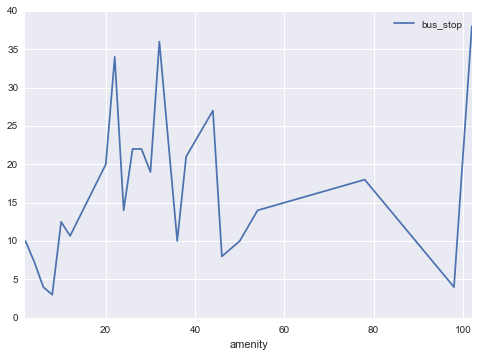

In [45]:
df2 = df.groupby('amenity').aggregate(np.average)
df2.plot()

Looking at this plot, we can easily conclude that there is not correlation between the number of amenity and the number of 

# Other ideas about the datasets

In order to improve the datasets and easy the analysis, we could implement:
- an advised format for numerical and non-numerical values when it makes sense (address types, phone numbers, etc.).
- some automatic corrections of values entered in these fields which might cover the main errors encountered (ie: the main deviant format).
- some mandatory fields could be interesting as well to ensure the completeness of the data linked to a specific element.

Pro / Cons regarding these suggestions:
- the first and the second suggestions will help a lot regarding the consistensy and the uniformity of the data while not limiting the freedom of participation. These one should be implemented ASAP.
- the third suggestion might not work with a project like OSM where everything is created collaboratively. The challenge of such a project is to provide an easy way to participate (even in a wrong way) but to bet on the facility to modify / review so that the quality of the data is ensured by all. Mandatory fields would introduce a lot of friction to the participation and might endanger the project.